# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [1]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM #, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2022-02-22 16:31:34--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 13.33.210.11, 13.33.210.24, 13.33.210.126, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|13.33.210.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105379 (103K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>] 102.91K  --.-KB/s    in 0.06s   

2022-02-22 16:31:34 (1.73 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [105379/105379]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(768, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-17,95143,3628,455,277,906,201,257,374,1513,915,...,279,271,4332,453,362,676,378,269,598,702
2022-02-18,87663,2656,590,242,782,216,188,364,1500,774,...,209,222,3738,396,382,707,312,227,483,681
2022-02-19,81576,2797,508,249,836,228,231,325,1527,854,...,216,214,3454,419,370,733,309,215,466,666
2022-02-20,71423,2334,245,270,695,164,196,286,1525,652,...,213,169,3189,204,258,470,230,207,388,527
2022-02-21,51930,1924,357,213,402,118,129,204,1204,371,...,151,90,2442,306,203,425,243,158,293,315


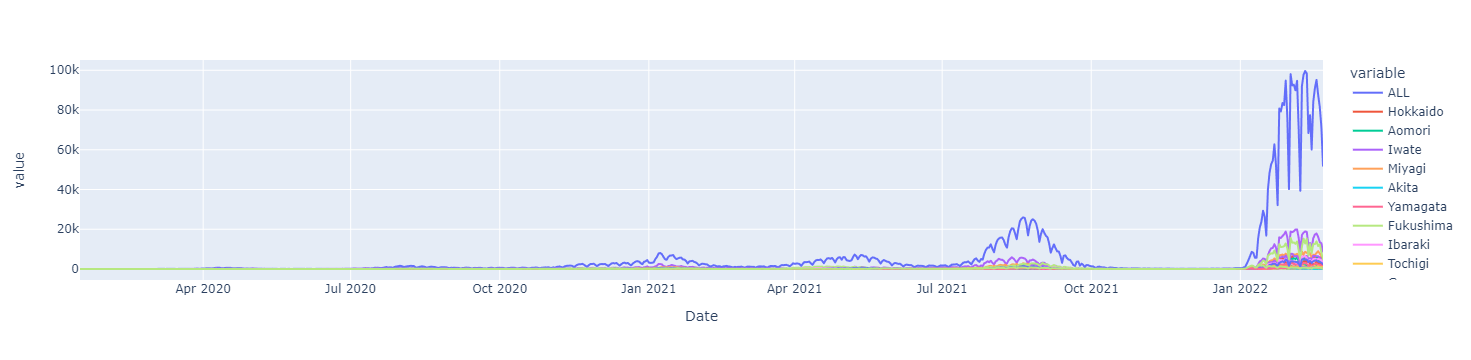

In [5]:
px.line(df, )

In [6]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).mean()
df_gr = df_gr.drop(df_gr.index[-1])
last_date = df_gr.index[-1]
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(110, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-23,46725.000000,1226.857143,186.857143,30.142857,186.000000,50.000000,61.285714,87.714286,641.285714,341.000000,...,225.285714,53.571429,1989.142857,225.428571,343.142857,600.428571,226.142857,243.285714,258.285714,1178.000000
2022-01-30,75534.285714,2217.857143,257.714286,118.000000,452.285714,200.857143,177.857143,302.857143,990.285714,583.857143,...,282.571429,139.142857,3449.285714,363.142857,391.571429,836.428571,342.571429,378.285714,479.142857,996.428571
2022-02-06,82612.142857,2809.142857,305.285714,148.000000,611.285714,188.142857,237.000000,481.571429,1372.714286,628.714286,...,251.857143,217.000000,3259.142857,482.142857,373.142857,594.571429,402.714286,334.428571,561.285714,641.857143
2022-02-13,81848.142857,3129.714286,373.857143,162.000000,673.000000,185.571429,183.714286,412.285714,1360.428571,687.142857,...,210.285714,243.428571,4024.857143,427.000000,401.857143,745.285714,399.000000,260.142857,529.000000,560.428571
2022-02-20,81582.714286,2680.571429,411.857143,222.428571,748.000000,192.142857,206.714286,353.571429,1306.000000,851.428571,...,226.571429,220.000000,3687.142857,410.285714,383.571429,700.857143,321.428571,219.142857,506.714286,606.142857


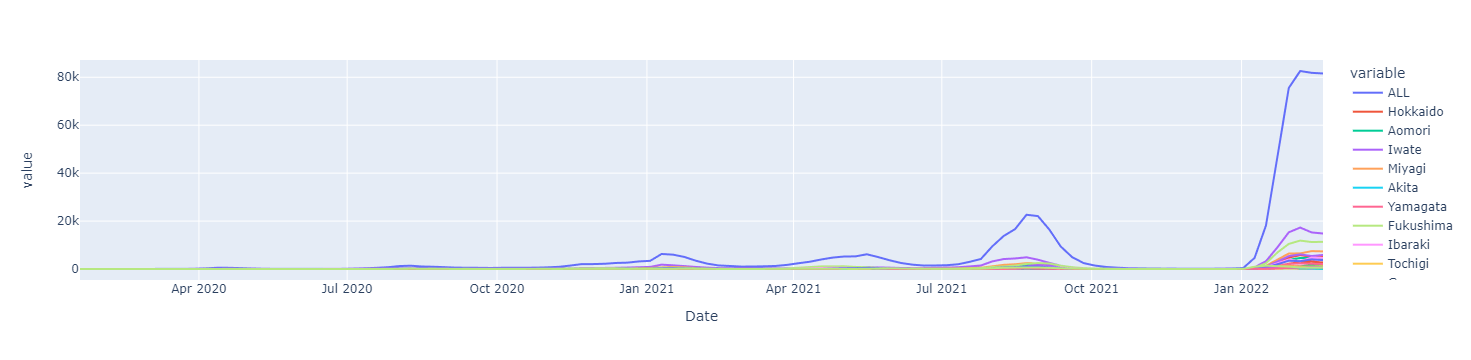

In [7]:
px.line(df_gr,)

### Scale

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### FE

In [9]:
forecast_weeks = 12
# df_fe = df_gr.ALL.to_frame()
df_fe = ts_all_sc.to_frame(name='ALL')

# add new rows for forecast
index_list = pd.date_range(ts_all_sc.index[-1]+relativedelta(weeks=1), ts_all_sc.index[-1]+relativedelta(weeks=forecast_weeks), freq='W')
df_fe = pd.concat([df_fe, pd.DataFrame(index=index_list)])

# shift
for i in range(forecast_weeks, forecast_weeks+12):
    df_fe[f'ALL_{i}_week_ago'] = df_fe.ALL.shift(i)
# df_fe[f'ALL_12_week_ago'] = df_fe.ALL.shift(12)
df_fe['year'] = df_fe.index.year
df_fe['month'] = df_fe.index.month
df_fe['weekofyear'] = df_fe.index.isocalendar().week
df_fe = df_fe.astype('float')
df_fe = df_fe.loc[df_fe.ALL_23_week_ago.dropna().index, :]
df_fe

,ALL,ALL_12_week_ago,ALL_13_week_ago,ALL_14_week_ago,ALL_15_week_ago,ALL_16_week_ago,ALL_17_week_ago,ALL_18_week_ago,ALL_19_week_ago,ALL_20_week_ago,ALL_21_week_ago,ALL_22_week_ago,ALL_23_week_ago,year,month,weekofyear
2020-06-28,0.000964,0.003298,0.001351,0.000466,0.000549,0.000405,0.000191,0.000130,0.000023,0.000002,0.000011,0.000002,0.000000,2020.0,6.0,26.0
2020-07-05,0.002198,0.006013,0.003298,0.001351,0.000466,0.000549,0.000405,0.000191,0.000130,0.000023,0.000002,0.000011,0.000002,2020.0,7.0,27.0
2020-07-12,0.003653,0.005996,0.006013,0.003298,0.001351,0.000466,0.000549,0.000405,0.000191,0.000130,0.000023,0.000002,0.000011,2020.0,7.0,28.0
2020-07-19,0.005828,0.004595,0.005996,0.006013,0.003298,0.001351,0.000466,0.000549,0.000405,0.000191,0.000130,0.000023,0.000002,2020.0,7.0,29.0
2020-07-26,0.008949,0.002842,0.004595,0.005996,0.006013,0.003298,0.001351,0.000466,0.000549,0.000405,0.000191,0.000130,0.000023,2020.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-17,NaN,0.565594,0.220093,0.056066,0.004664,0.002714,0.001792,0.001389,0.001354,0.001088,0.001640,0.002174,0.002323,2022.0,4.0,15.0
2022-04-24,NaN,0.914324,0.565594,0.220093,0.056066,0.004664,0.002714,0.001792,0.001389,0.001354,0.001088,0.001640,0.002174,2022.0,4.0,16.0
2022-05-01,NaN,1.000000,0.914324,0.565594,0.220093,0.056066,0.004664,0.002714,0.001792,0.001389,0.001354,0.001088,0.001640,2022.0,5.0,17.0
2022-05-08,NaN,0.990752,1.000000,0.914324,0.565594,0.220093,0.056066,0.004664,0.002714,0.001792,0.001389,0.001354,0.001088,2022.0,5.0,18.0


### split

In [10]:
X = df_fe.drop('ALL', axis=1)
y = df_fe.ALL
print(X.shape, y.shape)

(99, 15) (99,)


## functions

In [11]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_loss = np.Inf
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss < 0.001:
            if np.less(val_loss, self.best_val_loss):
                self.best_loss = loss
                self.best_val_loss = val_loss
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)

In [12]:
n_units = 32
dropout = 0.1
n_batch_size = 32
n_epochs = 10000

from keras.callbacks import EarlyStopping
es_loss = EarlyStopping(monitor='loss', patience=100)
es_val_loss = EarlyStopping(monitor='loss', patience=200)

def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # Second LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Third LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=n_epochs, batch_size=n_batch_size, verbose=0, 
        #callbacks=[es_loss]
        callbacks=[es_val_loss]
        #callbacks=[CustomEarlyStopping(patience=100)]
    )

    return model, history

## forecast

(87, 15) (87,)


2022-02-22 16:31:36.240155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-22 16:31:36.341606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-22 16:31:36.342004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-22 16:31:36.343371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

loss: 0.0012032
val_loss: 0.1526
CPU times: user 55.5 s, sys: 22.9 s, total: 1min 18s
Wall time: 57.6 s


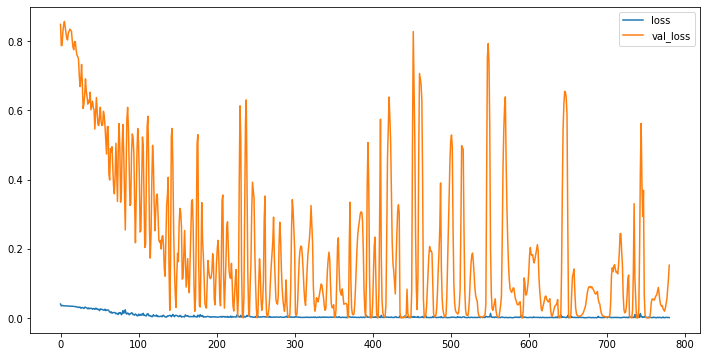

In [13]:
%%time

X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
print(X_train.shape, y_train.shape)

model, history = trainLSTM(X_train, y_train)
print('loss: {:.5}'.format(history.history['loss'][-1]))
print('val_loss: {:.5}'.format(history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 3984.1


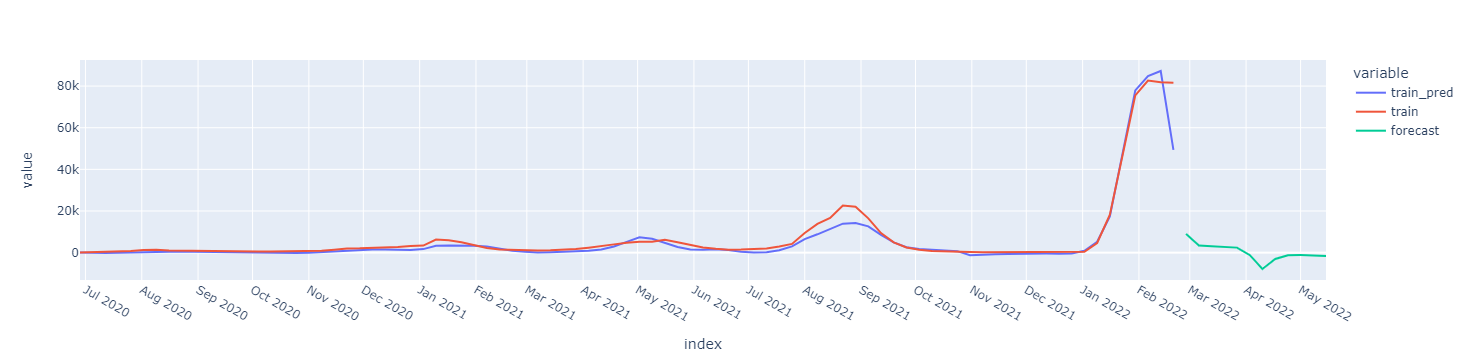

In [14]:
X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
y_train_index = y_train.index

y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index, name='train_pred')
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_index, name='train')

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

X_forecast = X[X.index > last_date]
y_forecast = y[y.index > last_date]
y_forecast_index = y_forecast.index

y_forecast = model.predict(X_forecast)
y_forecast = sc.inverse_transform(y_forecast).ravel()
y_forecast = pd.Series(y_forecast, index=y_forecast_index, name='forecast')

# plt.plot(y_pred, label='train pred')
# plt.plot(y_train, label='test')
# plt.plot(y_forecast, label='forecast')
# plt.legend()

fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()